In [ ]:
import gymnasium as gym

# Initialise the environment
env = gym.make("LunarLander-v3", render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)
for _ in range(1000):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()


In [ ]:
gym.pprint_registry()


===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v3
LunarLander-v3         LunarLanderContinuous-v3
===== toy_text =====
Blackjack-v1           CliffWalking-v0        FrozenLake-v1
FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                 Ant-v3                 Ant-v4
Ant-v5                 HalfCheetah-v2         HalfCheetah-v3
HalfCheetah-v4         HalfCheetah-v5         Hopper-v2
Hopper-v3              Hopper-v4              Hopper-v5
Humanoid-v2            Humanoid-v3            Humanoid-v4
Humanoid-v5            HumanoidStandup-v2     HumanoidStandup-v4
HumanoidStandup-v5     InvertedDoublePendulum-v2 InvertedDoublePendulum-v4
InvertedDoublePendulu

In [ ]:
import gymnasium as gym

env = gym.make("LunarLander-v3", render_mode="human")
observation, info = env.reset()

episode_over = False
while not episode_over:
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    episode_over = terminated or truncated

env.close()


# Train the Agent

In [ ]:
from collections import defaultdict
import gymnasium as gym
import numpy as np


class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


In [ ]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = gym.make("Blackjack-v1", sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)


In [7]:
from tqdm import tqdm

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:11<00:00, 9082.13it/s]


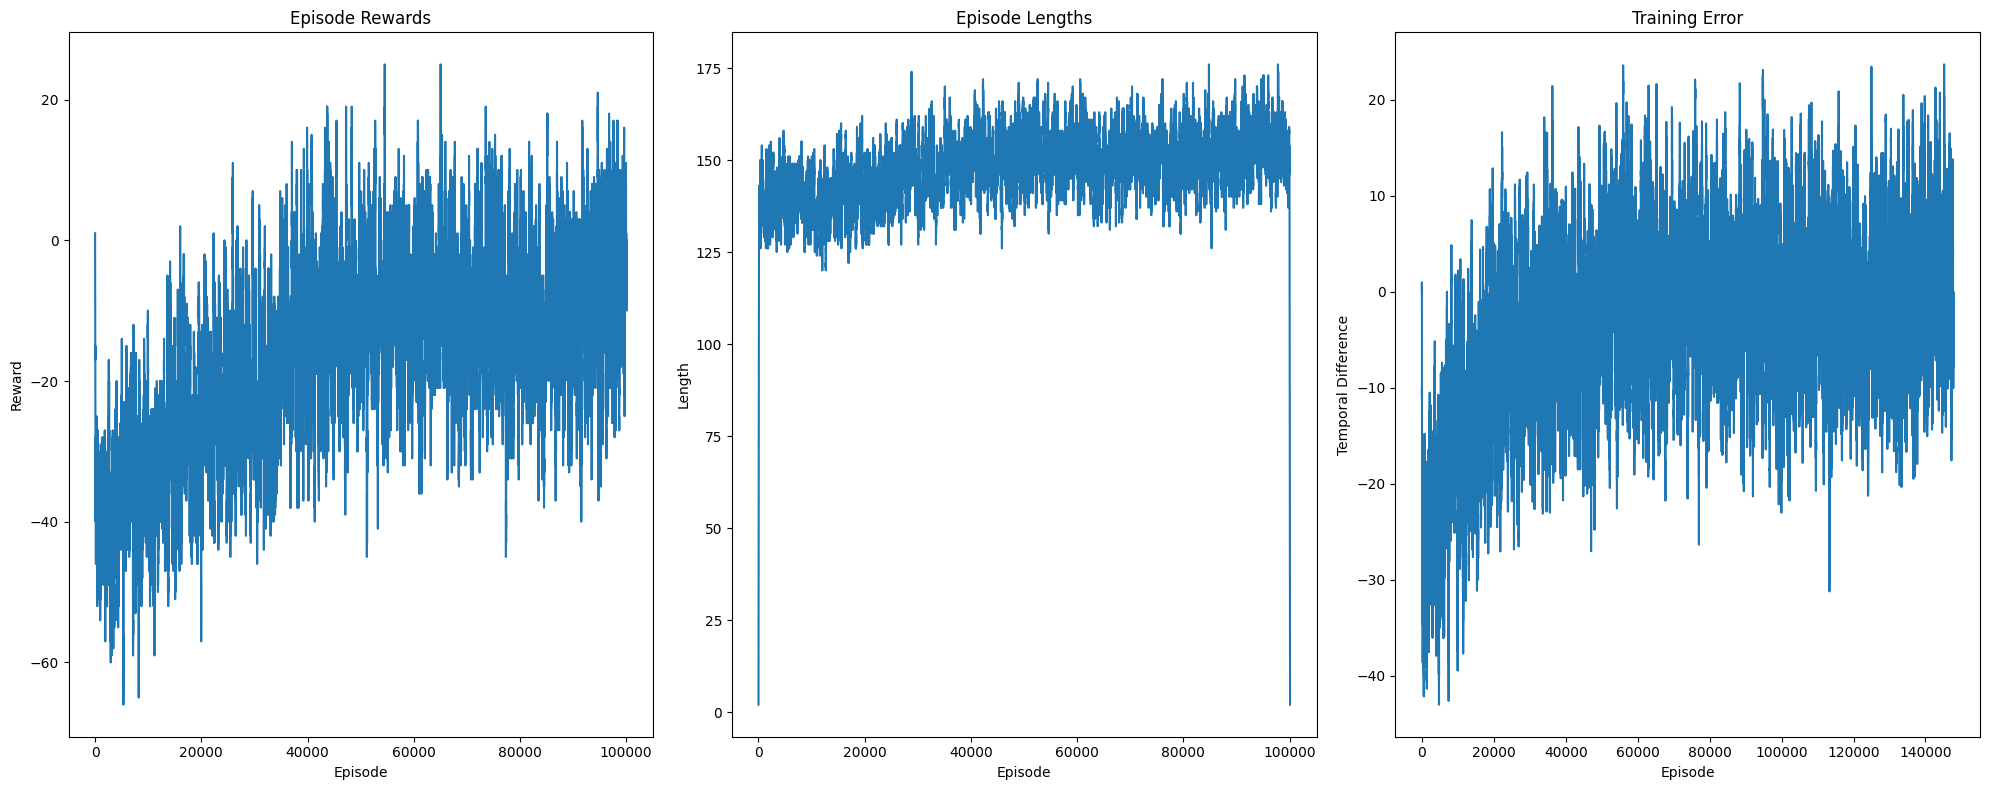

In [10]:
from matplotlib import pyplot as plt
# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# np.convolve will compute the rolling mean for 100 episodes

axs[0].plot(np.convolve(env.return_queue, np.ones(100)))
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(np.convolve(env.length_queue, np.ones(100)))
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

axs[2].plot(np.convolve(agent.training_error, np.ones(100)))
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()
